## Импорты библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

from typing import Optional
from scipy.special import logsumexp
from scipy import optimize
from numpy.linalg import norm
from math import floor
from tqdm import tqdm 
from itertools import product
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

import jax
from jax import numpy as jnp
from jax.numpy.linalg import norm 
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
pd.set_option('mode.chained_assignment', None)

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 25
plt.rcParams["figure.figsize"] = (16, 9)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
SEED = 42
EPS = 1e-9
ASY1_MATRIX = (-9, 9, 1, 0)
ASY2_MATRIX = (-1, 3, 2, -1)

## Служебные функции

In [19]:
def read_data(X_train_file: str, 
              y_train_file: str, 
              X_test_file: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    df_X_train = pd.read_csv(X_train_file, sep = ' ', header=None)
    df_y_train = pd.read_csv(y_train_file, sep = ' ', header=None)
    df_X_test = pd.read_csv(X_test_file, sep = ' ', header=None) 
    
    return df_X_train, df_y_train, df_X_test  


def retrieve_data(i: int) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    DIR_NAME = './task1_data/'
    X_train_file = DIR_NAME + f'task1_{i}_learn_X.csv'
    X_test_file = DIR_NAME + f'task1_{i}_test_X.csv'
    y_train_file = DIR_NAME + f'task1_{i}_learn_y.csv'
    
    return read_data(X_train_file, y_train_file, X_test_file)


def print_results(best_params, best_evidence, log):
    print(f'Best params: {best_params} \nBest_evidence = {best_evidence}\n\n')
    log = sorted(log, key = lambda v: -v[1])
    
    for params, evidence in log:
        print(f'For {params[0]} evidence  = {evidence}\n')
        

def make_answers(alg, X_test, dataset_id):
    DIR_NAME = './task1_answers/'
    
    p_pred = alg.predict_proba(X_test)[:,1].squeeze()
    y_NUM = np.where(p_pred >= 1./2, 1, 0)
    y_ASY1 = np.where(p_pred >= 18./19, 1, 0)
    y_ASY2 = np.where(p_pred >= 4./7, 1, 0)
    df = pd.DataFrame(columns = ['AUC', 'NUM', 'ASY1', 'ASY2'])
    df['AUC'] = p_pred
    df['NUM'] = y_NUM
    df['ASY1'] = y_ASY1
    df['ASY2'] = y_ASY2
    
    if dataset_id is not None:
        name = DIR_NAME + f'task1_{dataset_id}_ans.csv'
        df.to_csv(name, sep=',', index=False)

    return df


def pca_decomposition_plot(X, y):
    pca = PCA(n_components=2, svd_solver='full')
    transformed_x = pca.fit_transform(X)
    
    plt.scatter(transformed_x[:, 0], transformed_x[:, 1], c=y)
    plt.show()
    
    return pca


def sigmoid(x):
    return 1./(1 + np.exp(-x))


def jax_sigmoid(x):
    return 1./(1 + jnp.exp(-x))

## Реализации своих классов

In [7]:
class LogisticRegressionMAP():
    def __init__(self):
        self.best_score = None
        self.w_map = None

    def eval(self, X, y, A, cv, score):   
        total_score = 0.  
        count = 0
        
        for train_index, test_index in tqdm(cv.split(X, y)):
            def prob(w):     
                return np.sum(np.log(1 + np.exp(-X_train@w*y_train))) + 1./2 * w.T @ np.linalg.inv(A) @ w

            count += 1
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]           
            
            w0 = np.ones((X.shape[1]))
            res = minimize(prob, w0)
            w_map = res.x
            p = sigmoid(X_test@w_map)

            total_score += score(y_test.astype(int), p)
            
        self.w_map = w_map
        self.best_score = total_score/count
        
        return total_score/count
    
    def predict_proba(self, X):
        ps = np.zeros((X.shape[0], 2))
        p = sigmoid(X@self.w_map)
        ps[:, 0] = 1-p
        ps[:, 1] = p
        return ps

## Анализ данных (выборка 3)

Получение данных

In [8]:
X_train, y_train, X_test = retrieve_data(3)
y_train[y_train == 0] = -1

Проверка наличия пропусков

In [9]:
print(f"Общее число пропусков = {X_train.isna().sum().sum()}")

Общее число пропусков = 0


Проверка наличия выбросов

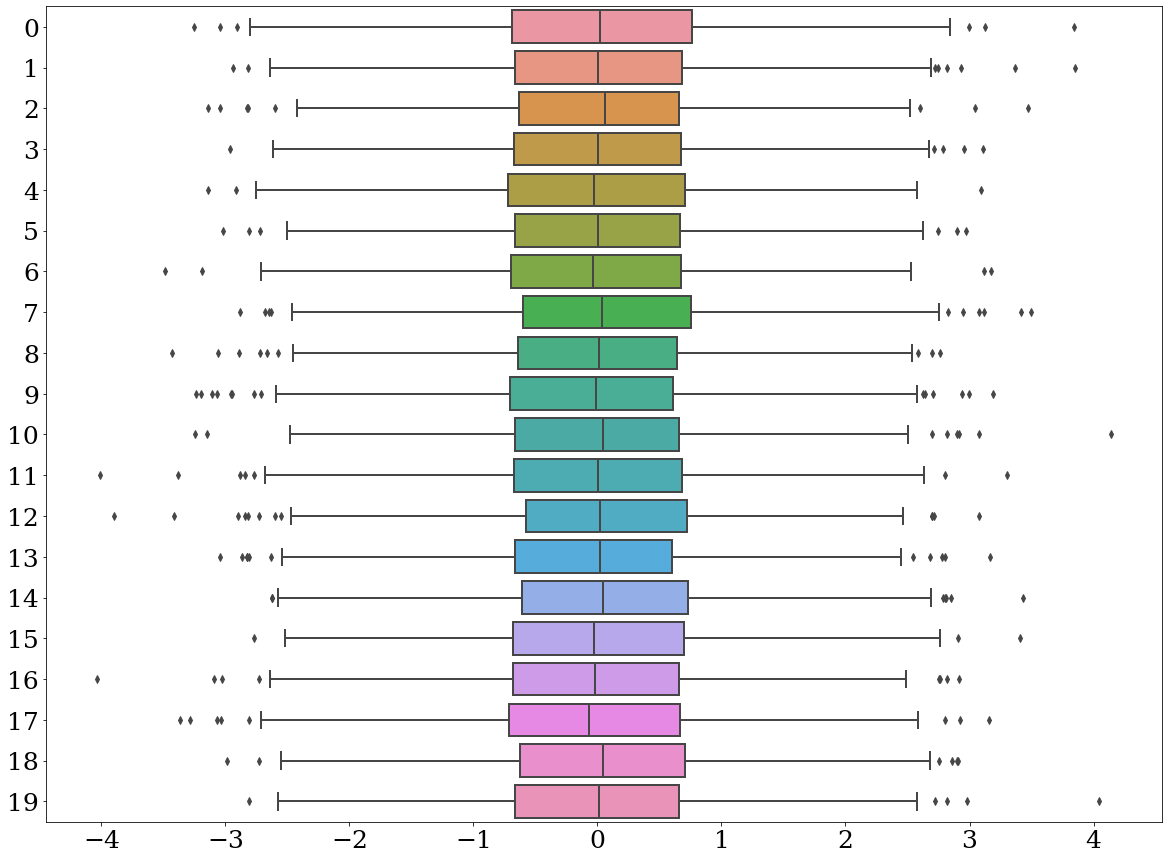

In [10]:
plt.figure(figsize=(20, 15))

sns.boxplot(data=X_train, orient='h', ax=plt.gca());

**Вывод:** Несмотря на то, что boxplot указывает на наличие выбросов в каждом признаке, все эти экстремальные значения не сильно отдалены от большинства значений. Поэтому можно считать, что выбросов в данных нет.

Нормировка данных

In [11]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

Визуализация данных с помощью PCA

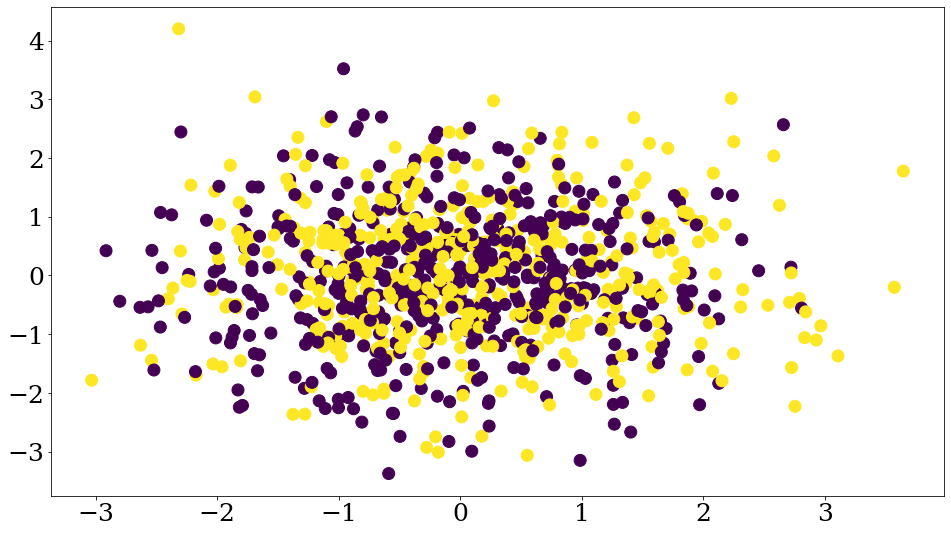

PCA explained variance ratio: 0.06277997473318872 0.06160240225611488


In [56]:
pca = pca_decomposition_plot(X_train_norm, y_train)
print("PCA explained variance ratio:", *pca.explained_variance_ratio_)

**Вывод:** Объекты из разных классов плохо отделимы в исходном признаковом пространстве

Баланс классов в обучающей выборке

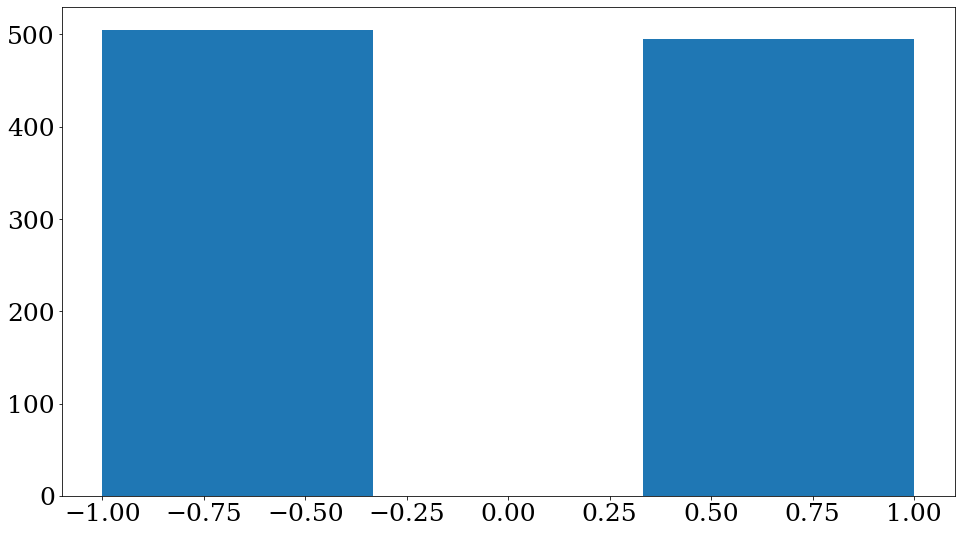

In [57]:
plt.hist(y_train, bins=3);

Проверка скоррелированности признаков

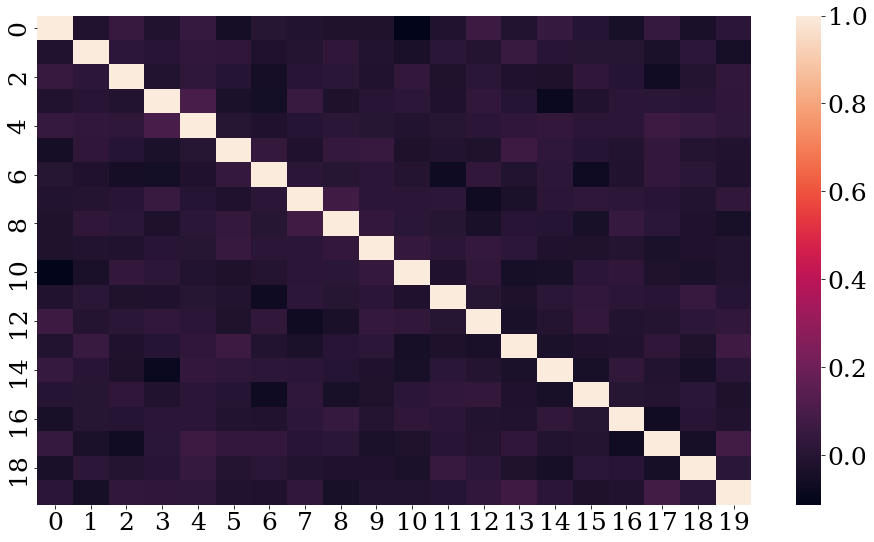

In [58]:
sns.heatmap(X_train_norm.corr());

**Вывод:** Признаки попарно независимы

## Обучение моделей

### Логистическая регрессия

In [14]:
estimator = LogisticRegression(max_iter=200, 
                               solver='liblinear',
                               random_state=SEED)

params = {
    'fitting__penalty': ['l1', 'l2'],
    'fitting__C': [0.002, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 
}

pipe = Pipeline(steps=[('scaling', StandardScaler()), ('fitting', estimator)])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
lr_grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc')

lr_grid.fit(X_train, y_train.values.squeeze())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('fitting',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'fitting__C': [0.002, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                        50],
                         'fitting__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [15]:
print(lr_grid.best_estimator_)
print(lr_grid.best_score_)

Pipeline(steps=[('scaling', StandardScaler()),
                ('fitting',
                 LogisticRegression(C=0.002, max_iter=200, random_state=42,
                                    solver='liblinear'))])
0.6819281928192819


### Случайный лес

In [75]:
rand_forest = RandomForestClassifier(
    n_estimators=100, 
    random_state=SEED)

params = {
    'fitting__max_depth': [1, 3, 5, 7, None],
}

pipe = Pipeline(steps=[('fitting', rand_forest)])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
rf_grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc')

rf_grid.fit(X_train_norm, y_train.values.squeeze())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('fitting',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'fitting__max_depth': [1, 3, 5, 7, None]},
             scoring='roc_auc')

In [76]:
print(rf_grid.best_estimator_)
print(rf_grid.best_score_)

Pipeline(steps=[('fitting',
                 RandomForestClassifier(max_depth=7, random_state=42))])
0.6565456545654565


### Naive Bayes

In [82]:
clf = GaussianNB()
parameters = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

nb_grid = GridSearchCV(clf, parameters, cv=cv, scoring='roc_auc')
nb_grid.fit(X_train_norm, y_train.values.squeeze())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GaussianNB(), param_grid={}, scoring='roc_auc')

In [83]:
print(nb_grid.best_estimator_)
print(nb_grid.best_score_)

GaussianNB()
0.673947394739474


### Логистическая регрессия с максимизацией апостериорной вер-ти

In [12]:
lr_map = LogisticRegressionMAP()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
lr_map_score = lr_map.eval(
    X_train_norm.values, 
    y_train.values.squeeze(), 
    A=np.eye(X_train.shape[1]), 
    cv=cv, 
    score=roc_auc_score
)
print(lr_map_score)

5it [00:00,  7.21it/s]

0.6812481248124811


## Получение предсказаний

In [22]:
ans = make_answers(lr_grid, X_test, 3)
ans.describe()

,AUC,NUM,ASY1,ASY2
count,1000.000000,1000.000000,1000.0,1000.00000
mean,0.497767,0.472000,0.0,0.11400
std,0.060157,0.499465,0.0,0.31797
min,0.327237,0.000000,0.0,0.00000
25%,0.456220,0.000000,0.0,0.00000
50%,0.496844,0.000000,0.0,0.00000
75%,0.539868,1.000000,0.0,0.00000
max,0.688018,1.000000,0.0,1.00000


## Вывод

Данная выборка содержит 20 попарно независимых признаков, соотношение классов сбалансированно.  
Критерием качества модели служит средний ROC-AUC на валидационных выборках, полученных через кросс-валидацию.

## Анализ данных (выборка 7)

In [31]:
X_train, y_train, X_test = retrieve_data(11)
y_train[y_train == 0] = -1
print(X_train.shape)

(1000, 100)


In [32]:
print(f"Общее число пропусков = {X_train.isna().sum().sum()}")

Общее число пропусков = 0


<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

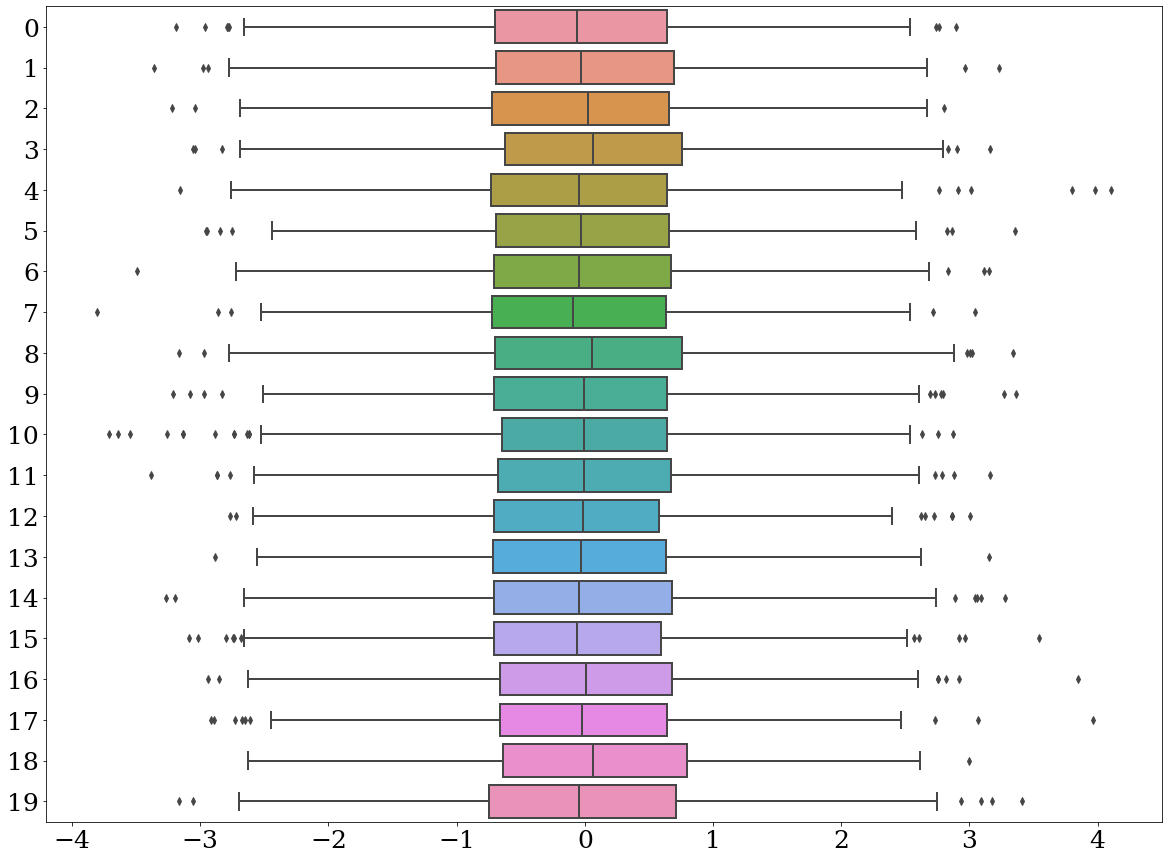

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

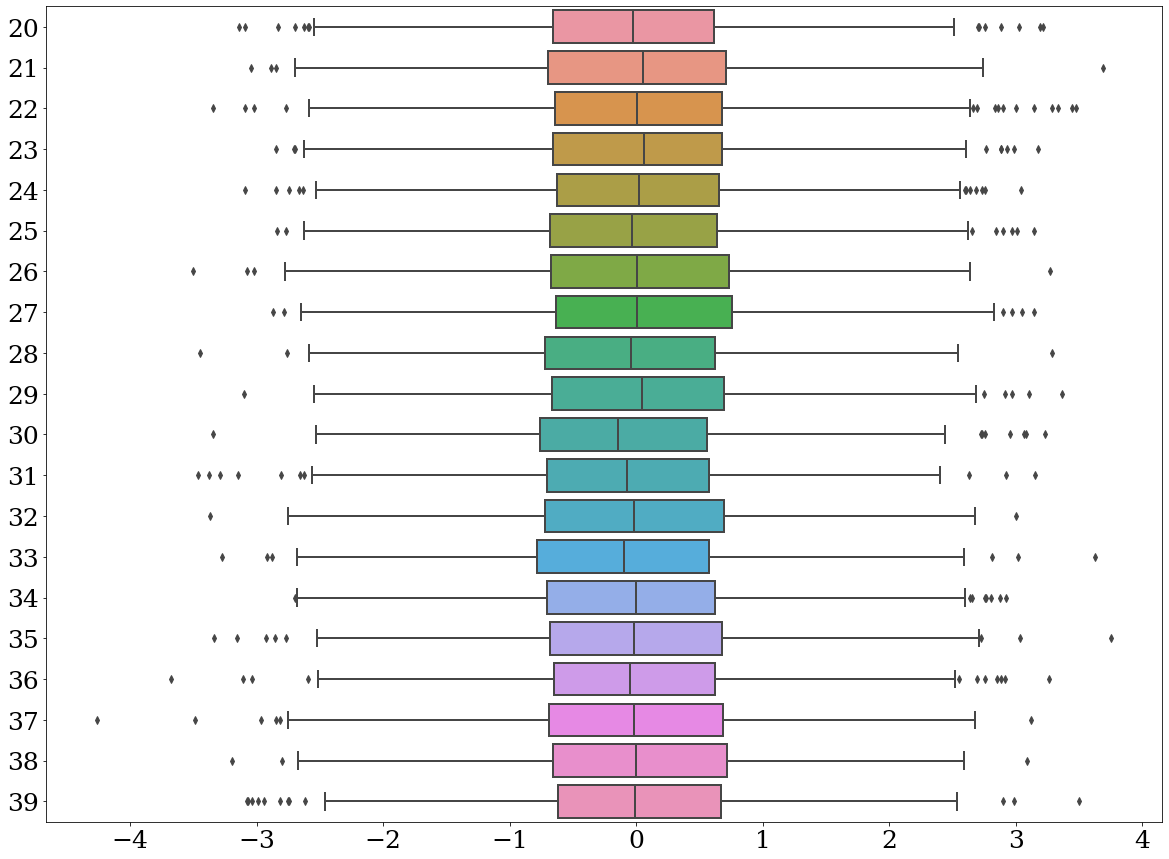

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

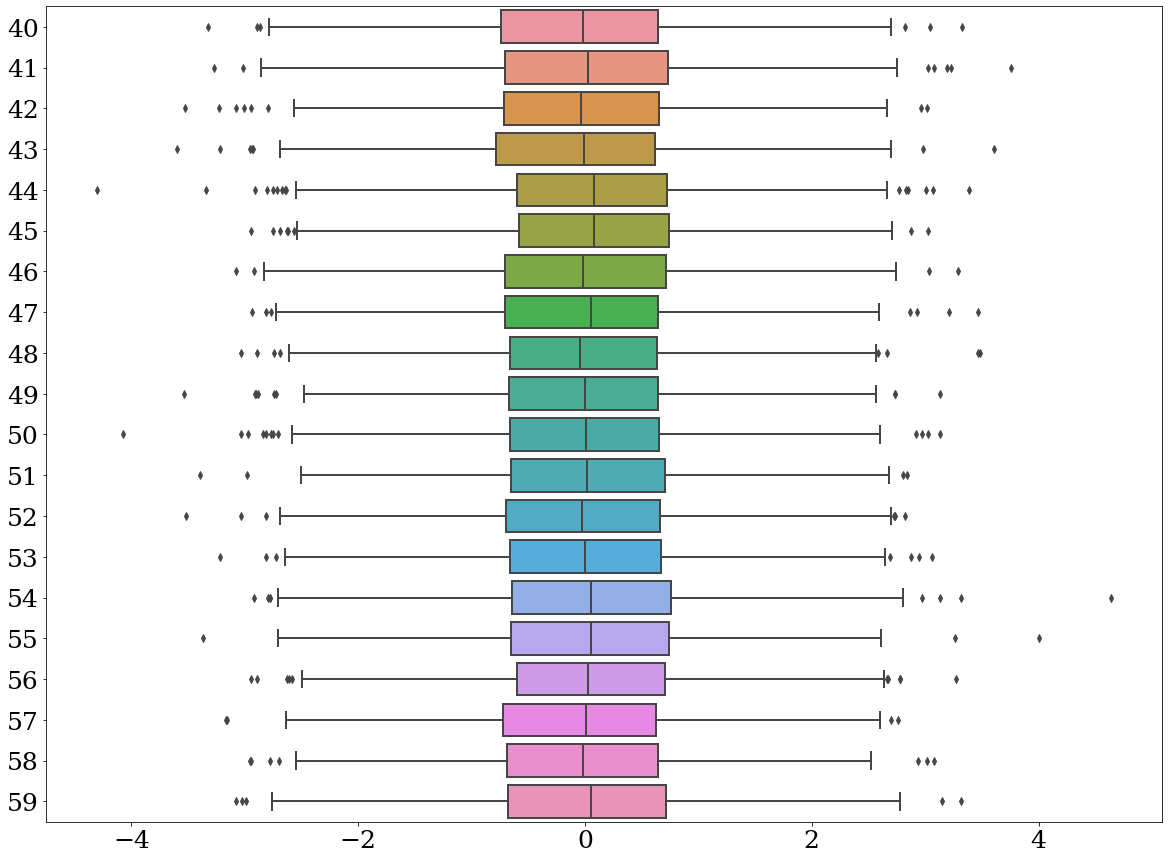

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

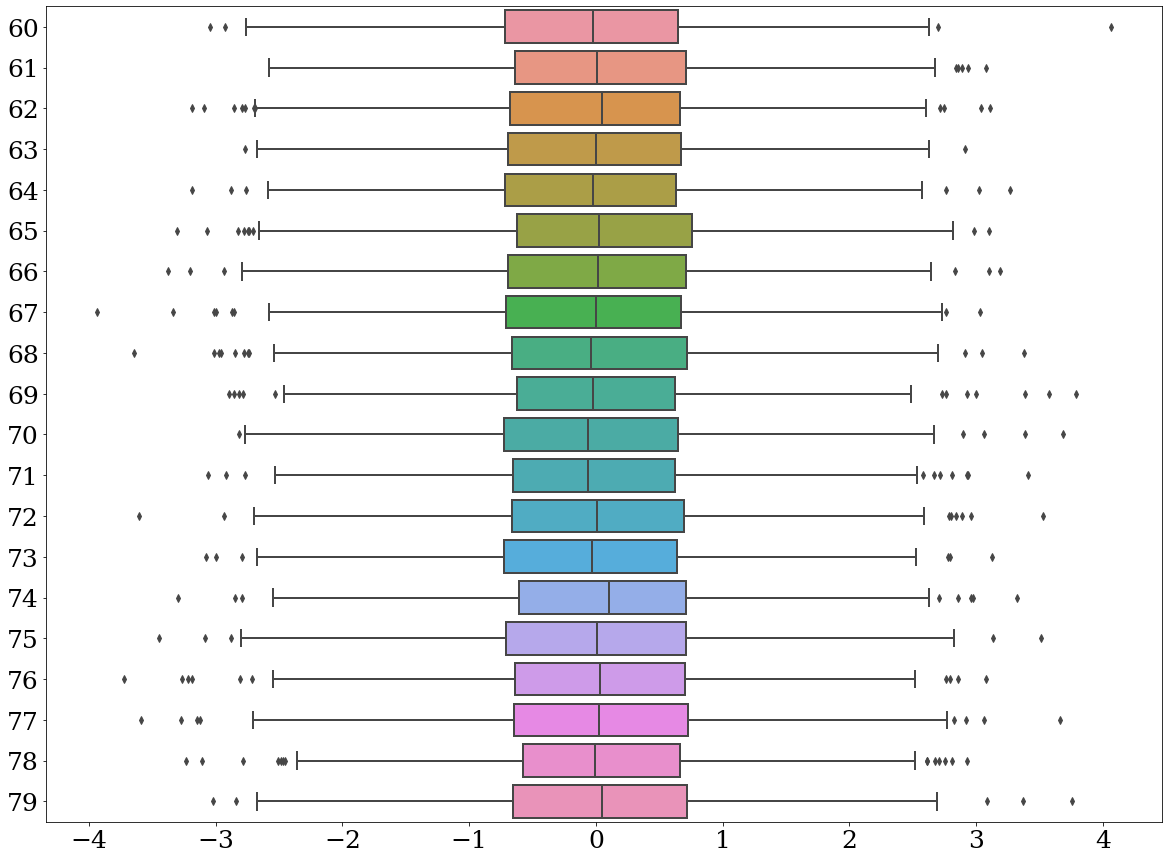

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

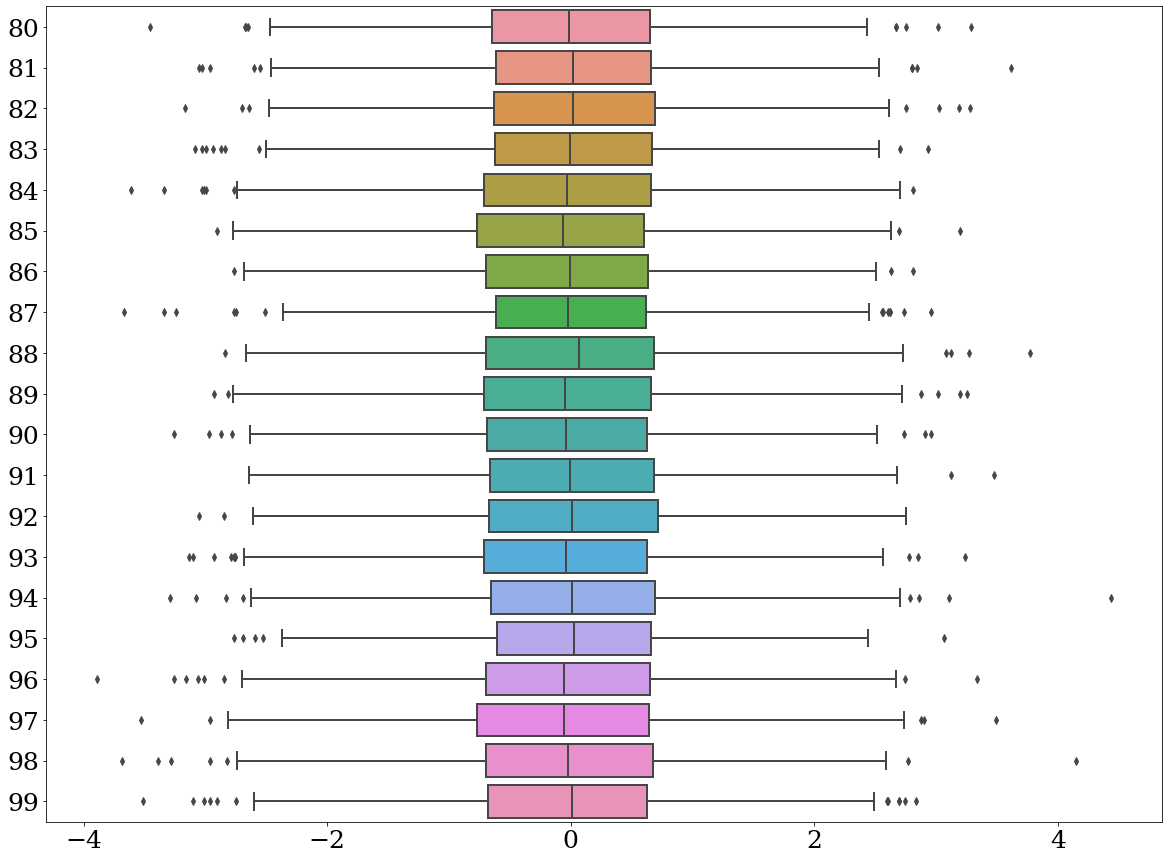

In [36]:
features_in_one_boxplot = 20

for start in range(0, X_train.shape[1], features_in_one_boxplot):
    plt.figure(figsize=(20, 15))
    
    curr_data = X_train.iloc[:, start:start+features_in_one_boxplot]
    sns.boxplot(data=curr_data, orient='h', ax=plt.gca())
    plt.show()

**Вывод:** Особых выбросов не обнаружено

Нормировка данных

In [37]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

Визуализация данных с помощью PCA

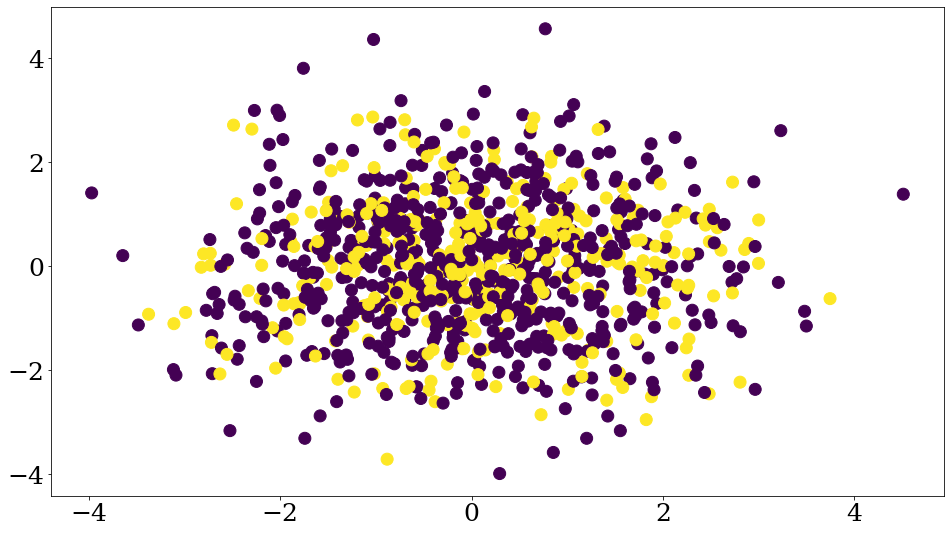

PCA explained variance ratio: 0.01732019426617523 0.01656456821384211


In [38]:
pca = pca_decomposition_plot(X_train_norm, y_train)
print("PCA explained variance ratio:", *pca.explained_variance_ratio_)

Баланс классов в обучающей выборке

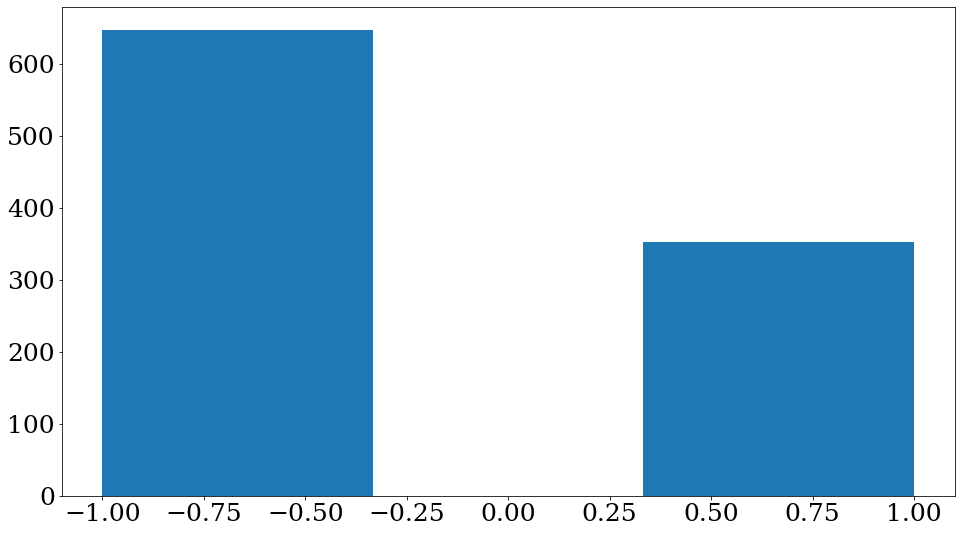

In [39]:
plt.hist(y_train, bins=3);

**Вывод:** Объектов первого класса почти в 2 раза больше, чем объектов второго класса

Проверка скоррелированности признаков

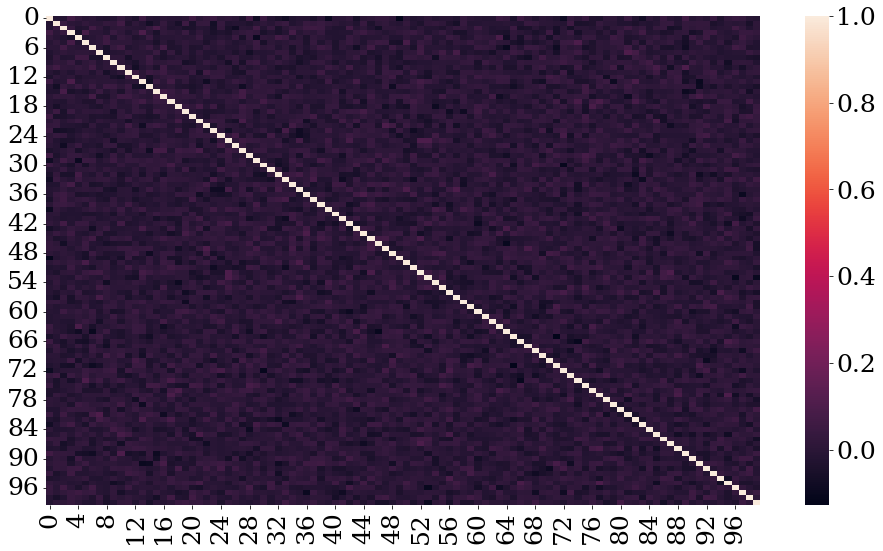

In [40]:
sns.heatmap(X_train_norm.corr());

**Вывод:** Признаки попарно независимы

## Обучение моделей

### Логистическая регрессия

In [41]:
estimator = LogisticRegression(max_iter=200, 
                               solver='liblinear',
                               class_weight='balanced',
                               random_state=SEED)

params = {
    'fitting__penalty': ['l1', 'l2'],
    'fitting__C': [0.002, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 
}

pipe = Pipeline(steps=[('scaling', StandardScaler()), ('fitting', estimator)])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
lr_grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc')

lr_grid.fit(X_train, y_train.values.squeeze())

print(lr_grid.best_estimator_)
print(lr_grid.best_score_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('fitting',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=200,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'fitting__C': [0.002, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                        50],
                         'fitting__penalty': ['l1', 'l2']},
             scoring='roc_auc')

Pipeline(steps=[('scaling', StandardScaler()),
                ('fitting',
                 LogisticRegression(C=0.002, class_weight='balanced',
                                    max_iter=200, penalty='l1', random_state=42,
                                    solver='liblinear'))])
0.5


### Случайный лес

In [44]:
rand_forest = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=SEED)

params = {
    'fitting__max_depth': [1, 3, 5, 7, None],
}

pipe = Pipeline(steps=[('fitting', rand_forest)])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
rf_grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc')

rf_grid.fit(X_train_norm, y_train.values.squeeze())

print(rf_grid.best_params_)
print(rf_grid.best_score_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('fitting',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'fitting__max_depth': [1, 3, 5, 7, None]},
             scoring='roc_auc')

{'fitting__max_depth': None}
0.7274964695747532


### Naive Bayes

In [47]:
clf = GaussianNB(priors=[2/3, 1/3])
parameters = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

nb_grid = GridSearchCV(clf, parameters, cv=cv, scoring='roc_auc')
nb_grid.fit(X_train_norm, y_train.values.squeeze())

print(nb_grid.best_score_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GaussianNB(priors=[0.6666666666666666,
                                          0.3333333333333333]),
             param_grid={}, scoring='roc_auc')

0.8608983513484004


### Логистическая регрессия с максимизацией апостериорной вер-ти

In [49]:
lr_map = LogisticRegressionMAP()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
lr_map_score = lr_map.eval(
    X_train_norm.values, 
    y_train.values.squeeze(), 
    A=np.eye(X_train.shape[1]), 
    cv=cv, 
    score=roc_auc_score
)
print(lr_map_score)

5it [00:39,  7.89s/it]

0.4395566625753327


## Получение предсказаний

In [53]:
ans = make_answers(nb_grid, X_test, 7)
ans.describe()

,AUC,NUM,ASY1,ASY2
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.304078,0.245300,0.005900,0.194800
std,0.266130,0.430286,0.076588,0.396066
min,0.000020,0.000000,0.000000,0.000000
25%,0.070806,0.000000,0.000000,0.000000
50%,0.226273,0.000000,0.000000,0.000000
75%,0.492758,0.000000,0.000000,0.000000
max,0.990183,1.000000,1.000000,1.000000


## Вывод

Данная выборка содержит 100 попарно независимых признаков, соотношение классов неравномерно и составляет примерно 2:1. Вследствие этого все модели учитывали этот фактор (будь то prior в байесовском классификаторе или нормировочные коэффициенты при подсчётё ф-ции потерь).  
Критерием качества модели служит средний ROC-AUC на валидационных выборках, полученных через кросс-валидацию.